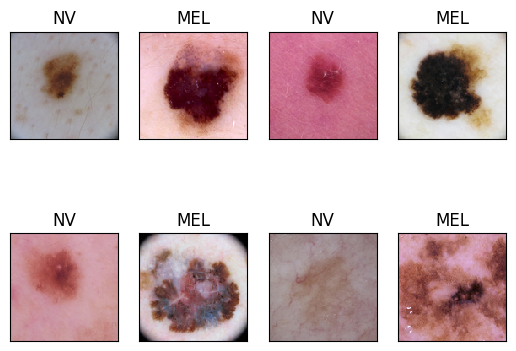

In [2]:
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

folder = ImageFolder('train', transform=torchvision.transforms.ToTensor())
loader = DataLoader(folder, batch_size=8, shuffle=True)

Xexamples, Yexamples = next(iter(loader))

for i in range(8):
    plt.subplot(2,4,i+1)  
    img = Xexamples[i].numpy().transpose(1, 2, 0)    
    plt.imshow(img, interpolation='none')
    plt.title('NV' if Yexamples[i] else 'MEL')
    plt.xticks([])
    plt.yticks([])

### Simple Model

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy as np
import random
torch.random.manual_seed(2)
torch.manual_seed(5)
torch.cuda.manual_seed(5)  # For CUDA
np.random.seed(5)
random.seed(5)
torch.backends.cudnn.deterministic = True  # Ensure deterministic CUDA behavior
torch.backends.cudnn.benchmark = False


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cnn_model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=5), #3 inputs 16 filters, 3x3 filter
     
    nn.MaxPool2d(2),    #Pooling
    nn.ReLU(),          #Activation function
    nn.Conv2d(16, 32, kernel_size=5),
    
    
    nn.MaxPool2d(2),
    nn.ReLU(),

    nn.Conv2d(32,64,kernel_size=5),
    
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(64, 128, kernel_size=5),  
    
    nn.MaxPool2d(2),                               
    nn.ReLU(),

    nn.Flatten(),       #Converts 2D to 1D
    nn.Linear(2048, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 2),
    
).to(device)

In [23]:
train_transform = transforms.Compose([
    transforms.Resize((128,128)),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomRotation(10),
    #transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset = ImageFolder('train', transform=train_transform)  #load images from train
val_dataset = ImageFolder('val', transform=val_transform)        #Load images from val
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)  #Load 32 images at a time and shuffle.
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

##### Train

In [24]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score

def train_classifier(model, train_data, val_data, hyperparams, device):

    model.to(device)  # Ensure model is on the right device
    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['lr'])    
    loss_func = torch.nn.CrossEntropyLoss()

    acc_history = []

    for epoch in range(hyperparams['n_epochs']):
        model.train()
        loss_sum = 0

        for Xbatch, Ybatch in tqdm(train_data):
            # Move data to the correct device (CPU or GPU)
            Xbatch, Ybatch = Xbatch.to(device), Ybatch.to(device)

            outputs = model(Xbatch)
            loss = loss_func(outputs, Ybatch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_sum += loss.item()

        model.eval()
        with torch.no_grad():
            val_acc = predict_and_evaluate(model, val_data, device)  # Pass device

        mean_loss = loss_sum / len(train_data)
        acc_history.append(val_acc)
        
        print(f'Epoch {epoch+1}: loss = {mean_loss:.4f}, val acc = {val_acc:.4f}')
    
    return acc_history


def predict_and_evaluate(model, data, device):
    model.eval()
    all_gold = [] 
    all_pred = []

    for Xbatch, Ybatch in data:
        Xbatch, Ybatch = Xbatch.to(device), Ybatch.to(device)  # Move to correct device
        outputs = model(Xbatch)
        predictions = outputs.argmax(dim=1)

        all_gold.extend(Ybatch.cpu().numpy())  # Move back to CPU before converting to NumPy
        all_pred.extend(predictions.cpu().numpy())

    return accuracy_score(all_gold, all_pred)


##### Train

In [25]:
history = train_classifier(cnn_model, train_loader, val_loader, {'lr': 0.0001, 'n_epochs': 10},device)

100%|██████████| 51/51 [01:11<00:00,  1.41s/it]


Epoch 1: loss = 0.6491, val acc = 0.6965


100%|██████████| 51/51 [00:58<00:00,  1.15s/it]


Epoch 2: loss = 0.5321, val acc = 0.7093


100%|██████████| 51/51 [01:04<00:00,  1.27s/it]


Epoch 3: loss = 0.5166, val acc = 0.7181


100%|██████████| 51/51 [01:06<00:00,  1.30s/it]


Epoch 4: loss = 0.4993, val acc = 0.6877


100%|██████████| 51/51 [00:58<00:00,  1.14s/it]


Epoch 5: loss = 0.4923, val acc = 0.7292


100%|██████████| 51/51 [00:57<00:00,  1.13s/it]


Epoch 6: loss = 0.4866, val acc = 0.7364


100%|██████████| 51/51 [01:05<00:00,  1.28s/it]


Epoch 7: loss = 0.4731, val acc = 0.7236


100%|██████████| 51/51 [00:57<00:00,  1.13s/it]


Epoch 8: loss = 0.4616, val acc = 0.7364


100%|██████████| 51/51 [00:58<00:00,  1.14s/it]


Epoch 9: loss = 0.4591, val acc = 0.7540


100%|██████████| 51/51 [01:06<00:00,  1.30s/it]


Epoch 10: loss = 0.4611, val acc = 0.7460


### Model & Data Augmentation

In [26]:
train_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset = ImageFolder('train', transform=train_transform)  #load images from train
val_dataset = ImageFolder('val', transform=val_transform)        #Load images from val
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)  #Load 32 images at a time and shuffle.
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

We tried with all transformers at once and each one separatly. The most efficient considering Loss, Acc and train time is including only the Normalize. 

In [27]:
history = train_classifier(cnn_model, train_loader, val_loader, {'lr': 0.0001, 'n_epochs': 10},device)

100%|██████████| 51/51 [03:43<00:00,  4.38s/it]


Epoch 1: loss = 1.1506, val acc = 0.7428


100%|██████████| 51/51 [01:49<00:00,  2.14s/it]


Epoch 2: loss = 0.4835, val acc = 0.7380


100%|██████████| 51/51 [02:11<00:00,  2.58s/it]


Epoch 3: loss = 0.4672, val acc = 0.7524


100%|██████████| 51/51 [01:27<00:00,  1.71s/it]


Epoch 4: loss = 0.4468, val acc = 0.7564


100%|██████████| 51/51 [02:20<00:00,  2.75s/it]


Epoch 5: loss = 0.4450, val acc = 0.7652


100%|██████████| 51/51 [02:01<00:00,  2.39s/it]


Epoch 6: loss = 0.4368, val acc = 0.7732


100%|██████████| 51/51 [01:59<00:00,  2.35s/it]


Epoch 7: loss = 0.4283, val acc = 0.7692


100%|██████████| 51/51 [02:40<00:00,  3.15s/it]


Epoch 8: loss = 0.4279, val acc = 0.7716


100%|██████████| 51/51 [02:04<00:00,  2.45s/it]


Epoch 9: loss = 0.4216, val acc = 0.7740


100%|██████████| 51/51 [02:09<00:00,  2.53s/it]


Epoch 10: loss = 0.4212, val acc = 0.7804


##### Test

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


test_transform = transforms.Compose([  
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])
test_dataset = ImageFolder('test', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)  

def evaluate_test_set(model, test_loader, device):
    model.eval()
    loss_func = nn.CrossEntropyLoss()
    test_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for Xbatch, Ybatch in tqdm(test_loader, desc="Evaluating Test Set"):
            Xbatch, Ybatch = Xbatch.to(device), Ybatch.to(device)
            outputs = model(Xbatch)
            loss = loss_func(outputs, Ybatch)
            test_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(Ybatch.cpu().numpy())

    # Calculate metrics
    avg_loss = test_loss / sum(len(batch) for batch in test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average = 'weighted')
    
    print(classification_report(all_labels,all_preds))


    # Print results
    print("\nTest Set Evaluation Results:")
    print("---------------------------")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': all_preds,
        'true_labels': all_labels
    }


In [10]:
test_results = evaluate_test_set(cnn_model, test_loader, device)

Evaluating Test Set: 100%|██████████| 11/11 [00:14<00:00,  1.29s/it]


              precision    recall  f1-score   support

           0       0.97      0.33      0.49       683
           1       0.59      0.99      0.74       683

    accuracy                           0.66      1366
   macro avg       0.78      0.66      0.61      1366
weighted avg       0.78      0.66      0.61      1366


Test Set Evaluation Results:
---------------------------
Average Loss: 0.3186
Accuracy: 0.6574
Precision: 0.7820
Recall: 0.6574
F1 Score: 0.6148


### Model with BatchNorm

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy as np
import random
torch.random.manual_seed(2)
torch.manual_seed(5)
torch.cuda.manual_seed(5)  # For CUDA
np.random.seed(5)
random.seed(5)
torch.backends.cudnn.deterministic = True  # Ensure deterministic CUDA behavior
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_cnn_model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=5), #3 inputs 16 filters, 3x3 filter
    nn.BatchNorm2d(16), #Normalize the 16 maps to reduce overfit
    nn.MaxPool2d(2),    #Pooling
    nn.ReLU(),          #Activation function
    nn.Conv2d(16, 32, kernel_size=5),
    nn.BatchNorm2d(32),
    
    nn.MaxPool2d(2),
    nn.ReLU(),

    nn.Conv2d(32,64,kernel_size=5),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(64, 128, kernel_size=5),  
    nn.BatchNorm2d(128),
    nn.MaxPool2d(2),                               
    nn.ReLU(),

    nn.Flatten(),       #Converts 2D to 1D
    nn.Linear(2048, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 2),
    
).to(device)


In [12]:
train_transform = transforms.Compose([
    transforms.Resize((128,128)),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomRotation(10),
    #transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([  
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = ImageFolder('test', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)  


train_dataset = ImageFolder('train', transform=train_transform)  #load images from train
val_dataset = ImageFolder('val', transform=val_transform)        #Load images from val
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)  #Load 32 images at a time and shuffle.
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [14]:
history = train_classifier(batch_cnn_model, train_loader, val_loader, {'lr': 0.0001, 'n_epochs': 10},device)

100%|██████████| 51/51 [01:41<00:00,  1.99s/it]


Epoch 1: loss = 0.4811, val acc = 0.7612


100%|██████████| 51/51 [01:14<00:00,  1.46s/it]


Epoch 2: loss = 0.4054, val acc = 0.7907


100%|██████████| 51/51 [01:15<00:00,  1.48s/it]


Epoch 3: loss = 0.3790, val acc = 0.7995


100%|██████████| 51/51 [01:25<00:00,  1.68s/it]


Epoch 4: loss = 0.3580, val acc = 0.8075


100%|██████████| 51/51 [01:05<00:00,  1.29s/it]


Epoch 5: loss = 0.3402, val acc = 0.8131


100%|██████████| 51/51 [01:07<00:00,  1.31s/it]


Epoch 6: loss = 0.3168, val acc = 0.8251


100%|██████████| 51/51 [01:18<00:00,  1.54s/it]


Epoch 7: loss = 0.2874, val acc = 0.7899


100%|██████████| 51/51 [01:36<00:00,  1.90s/it]


Epoch 8: loss = 0.2702, val acc = 0.8331


100%|██████████| 51/51 [01:10<00:00,  1.39s/it]


Epoch 9: loss = 0.2438, val acc = 0.8403


100%|██████████| 51/51 [01:10<00:00,  1.38s/it]


Epoch 10: loss = 0.2232, val acc = 0.8275


In [15]:
bach_test_results = evaluate_test_set(batch_cnn_model, test_loader, device)

Evaluating Test Set: 100%|██████████| 11/11 [00:09<00:00,  1.21it/s]


              precision    recall  f1-score   support

           0       0.89      0.76      0.82       683
           1       0.79      0.90      0.84       683

    accuracy                           0.83      1366
   macro avg       0.84      0.83      0.83      1366
weighted avg       0.84      0.83      0.83      1366


Test Set Evaluation Results:
---------------------------
Average Loss: 0.1732
Accuracy: 0.8331
Precision: 0.8398
Recall: 0.8331
F1 Score: 0.8323


### ResBlock Model And Batch

In [16]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=5):
        super().__init__()
        # Main path
        self.module = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=2), 
            nn.ReLU(),
            nn.BatchNorm2d(out_channels)  
        )
        self.adjust_channels = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, inputs):
        out = self.module(inputs)
        skip = self.adjust_channels(inputs)
        return out + skip


res_cnn_model = nn.Sequential(
    
    ResBlock(3, 16, kernel_size=5),
    nn.MaxPool2d(2), 

    
    ResBlock(16, 32, kernel_size=5),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2), 

  
    ResBlock(32, 64, kernel_size=5),
    nn.MaxPool2d(2), 

   
    ResBlock(64, 128, kernel_size=5),
    nn.MaxPool2d(2),  

    
    nn.Flatten(),      
    nn.Linear(8192, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 2),
).to(device)

In [17]:
history_res = train_classifier(res_cnn_model, train_loader, val_loader, {'lr': 0.0001, 'n_epochs': 10},device)

100%|██████████| 51/51 [01:33<00:00,  1.83s/it]


Epoch 1: loss = 0.4071, val acc = 0.8195


100%|██████████| 51/51 [01:41<00:00,  1.99s/it]


Epoch 2: loss = 0.3301, val acc = 0.8315


100%|██████████| 51/51 [01:36<00:00,  1.88s/it]


Epoch 3: loss = 0.3059, val acc = 0.8211


100%|██████████| 51/51 [01:41<00:00,  1.99s/it]


Epoch 4: loss = 0.2801, val acc = 0.8339


100%|██████████| 51/51 [01:33<00:00,  1.83s/it]


Epoch 5: loss = 0.2310, val acc = 0.8578


100%|██████████| 51/51 [01:39<00:00,  1.96s/it]


Epoch 6: loss = 0.1975, val acc = 0.8626


100%|██████████| 51/51 [01:33<00:00,  1.82s/it]


Epoch 7: loss = 0.1468, val acc = 0.8522


100%|██████████| 51/51 [01:33<00:00,  1.83s/it]


Epoch 8: loss = 0.1136, val acc = 0.8538


100%|██████████| 51/51 [01:33<00:00,  1.84s/it]


Epoch 9: loss = 0.0777, val acc = 0.8546


100%|██████████| 51/51 [01:34<00:00,  1.84s/it]


Epoch 10: loss = 0.0565, val acc = 0.8442


In [18]:
res_test_results = evaluate_test_set(res_cnn_model, test_loader, device)

Evaluating Test Set: 100%|██████████| 11/11 [00:12<00:00,  1.18s/it]


              precision    recall  f1-score   support

           0       0.89      0.81      0.84       683
           1       0.82      0.90      0.86       683

    accuracy                           0.85      1366
   macro avg       0.86      0.85      0.85      1366
weighted avg       0.86      0.85      0.85      1366


Test Set Evaluation Results:
---------------------------
Average Loss: 0.2079
Accuracy: 0.8521
Precision: 0.8552
Recall: 0.8521
F1 Score: 0.8518


Confusion Matrix:
[[550 133]
 [ 69 614]]


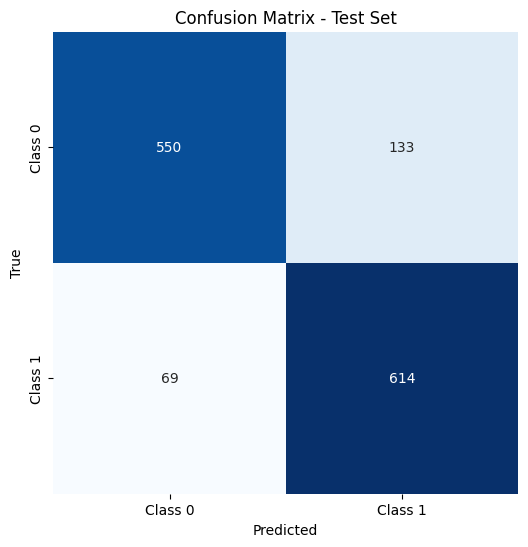

In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

preds = res_test_results['predictions']
true_labels = res_test_results['true_labels']

# Compute confusion matrix
cm = confusion_matrix(true_labels, preds)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")
plt.show()

Missclassified images

<!-- ## Vgg - Transfer Learning -->

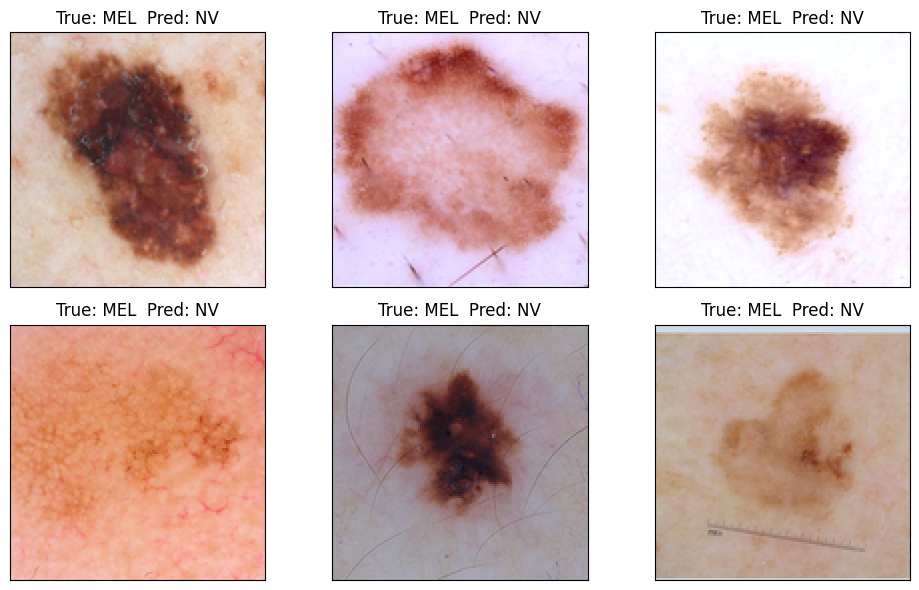

In [20]:
import matplotlib.pyplot as plt

class_names = test_dataset.classes  

error_images = []
error_gold = []
error_pred = []

res_cnn_model.eval()

with torch.no_grad():
    for Xbatch, Ybatch in test_loader:
        Xbatch, Ybatch = Xbatch.to(device), Ybatch.to(device)
        outputs = res_cnn_model(Xbatch)
        preds = outputs.argmax(dim=1)

        for i in range(len(Ybatch)):
            if preds[i] != Ybatch[i]:
                error_images.append(Xbatch[i].cpu())  
                error_gold.append(class_names[Ybatch[i].item()])  
                error_pred.append(class_names[preds[i].item()])  

fig = plt.figure(figsize=(10, 6))
for i in range(min(6, len(error_images))):
    plt.subplot(2, 3, i + 1)
    img = error_images[i].permute(1, 2, 0).numpy()  
    img = img * 0.229 + 0.485  
    plt.imshow(img.clip(0, 1))  
    plt.title(f"True: {error_gold[i]}  Pred: {error_pred[i]}")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()


Correctly classified

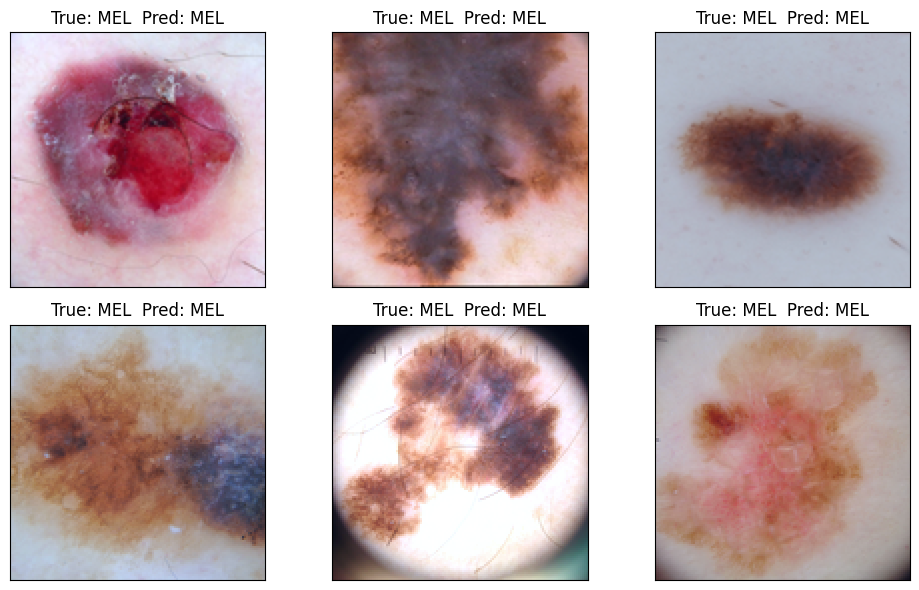

In [21]:
import matplotlib.pyplot as plt

class_names = test_dataset.classes  

correct_images = []
correct_gold = []
correct_pred = []

res_cnn_model.eval()

with torch.no_grad():
    for Xbatch, Ybatch in test_loader:
        Xbatch, Ybatch = Xbatch.to(device), Ybatch.to(device)
        outputs = res_cnn_model(Xbatch)
        preds = outputs.argmax(dim=1)

        for i in range(len(Ybatch)):
            if preds[i] == Ybatch[i]:
                correct_images.append(Xbatch[i].cpu())  
                correct_gold.append(class_names[Ybatch[i].item()])  
                correct_pred.append(class_names[preds[i].item()])  

fig = plt.figure(figsize=(10, 6))
for i in range(min(6, len(correct_images))):
    plt.subplot(2, 3, i + 1)
    img = correct_images[i].permute(1, 2, 0).numpy()  
    img = img * 0.229 + 0.485  
    plt.imshow(img.clip(0, 1))  
    plt.title(f"True: {correct_gold[i]}  Pred: {correct_pred[i]}")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()


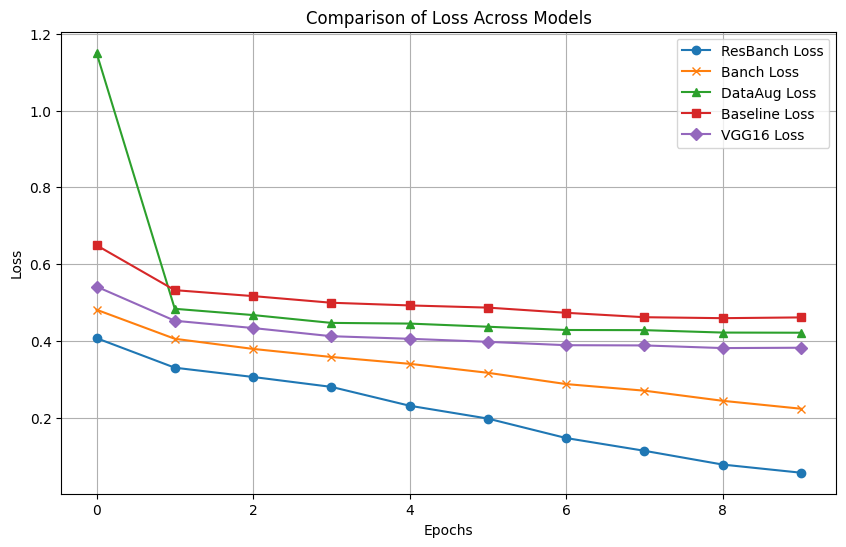

In [29]:
base_loss_array = np.array([0.6491, 0.5321, 0.5166, 0.4993, 0.4923, 0.4866, 0.4731, 0.4616, 0.4591, 0.4611])


aug_loss_array = np.array([1.1506, 0.4835, 0.4672, 0.4468, 0.4450, 0.4368, 0.4283, 0.4279, 0.4216, 0.4212])

banch_loss = np.array([0.4811, 0.4054, 0.3790, 0.3580, 0.3402, 0.3168, 0.2874, 0.2702, 0.2438, 0.2232])

res_batch_loss = np.array([0.4071, 0.3301, 0.3059, 0.2801, 0.2310, 0.1975, 0.1468, 0.1136, 0.0777, 0.0565])

vgg16_loss = np.array([0.5414,0.4524,0.4334,0.4121, 0.4054,0.3975,0.3887,0.3881,0.3812,0.3821])

plt.figure(figsize=(10, 6))

plt.plot(res_batch_loss, label="ResBanch Loss", marker='o')
plt.plot(banch_loss, label="Banch Loss", marker='x')
plt.plot(aug_loss_array, label="DataAug Loss", marker='^')
plt.plot(base_loss_array, label="Baseline Loss", marker='s')
plt.plot(vgg16_loss, label="VGG16 Loss", marker='D')

plt.title('Comparison of Loss Across Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()




### VGG-Transfer Learning

We used Google Colab to run the vgg model

In [ ]:
import torchvision
# Load pre-trained VGG16
weights_id = torchvision.models.VGG16_Weights.IMAGENET1K_V1
vgg_model = torchvision.models.vgg16(weights=weights_id).to(device)
vgg_model.eval()  # Set to evaluation mode

# Freeze the weights
for param in vgg_model.parameters():
    param.requires_grad = False  # No gradient updates

# Use only the feature extractor part (exclude classifier)
vgg_features = vgg_model.features  # Outputs 512x7x7 feature maps for 224x224 input


In [ ]:
vgg_transforms = weights_id.transforms()  # Resize to 224x224, crop, normalize


# Update datasets
train_dataset = ImageFolder('/content/drive/MyDrive/a5_data/train', transform=vgg_transforms)
val_dataset = ImageFolder('/content/drive/MyDrive/a5_data/val', transform=vgg_transforms)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)  # Smaller batch size for memory
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_data =  ImageFolder('/content/drive/MyDrive/a5_data/test', transform=vgg_transforms)
test_loader = DataLoader(test_data, batch_size = 128,shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models


# Change the last layer to match 2 classes 
vgg_model.classifier[-1] = nn.Linear(vgg_model.classifier[-1].in_features, 2)


# Flytta till GPU om tillgängligt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_model.to(device)


# Definiera hyperparametrar
hyperparams = {
    'lr': 0.0001,
    'n_epochs': 10
}

In [ ]:
acc_history = train_classifier(vgg_model, train_loader, val_loader, hyperparams, device = device)


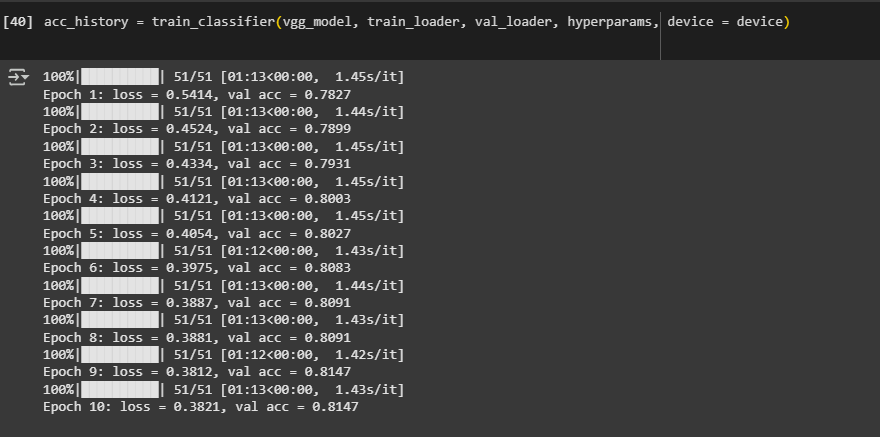

In [ ]:
test_results = evaluate_test_set(vgg_model, test_loader, device)

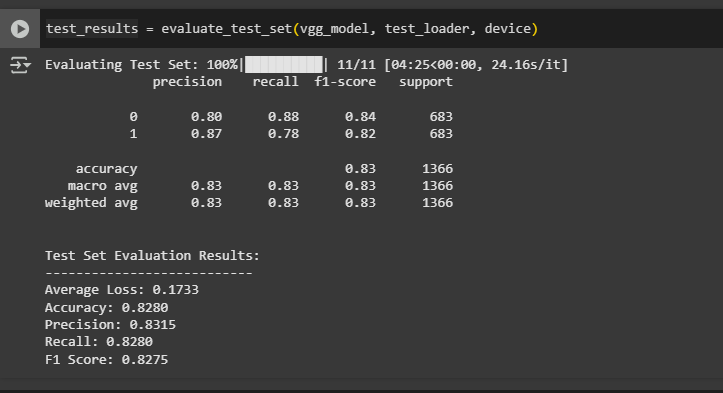